In [1]:
### Get Quality Metrics

# Import libraries
import pandas as pd
import numpy as np
from obspy.clients.fdsn import Client
from obspy import UTCDateTime, Trace
client = Client("IRIS")

### Module structure
- provide start and endtime, return percentage good hours between them
- provide start and end time, return good data between them
- provide start and endtime, return good/bad time series
- provide start and endtime, return data with good/bad time series

In [2]:
# want to read a specific quality url
netID='XE'
staID='CC01'
locID=''
chaID='BHZ'

url =f'https://obsic-metrics.whoi.edu/static/images/quality/{netID}/{staID}_{chaID}.txt'

# read in the data
data = pd.read_csv(url, delimiter=',', header=2, names=['DateTime', 'Quality'])

# now specify start and end window
starttime = '2018-07-26T00:00:00'
endtime = '2018-07-26T23:59:54'

# concatenate the binary good/not good hourly string
quality_string = ''.join(data['Quality'].astype(str).values)

# for a starttime, calculate the index into the quality string. this is the `hour` since the start of the quality string
# (we assume the quality string starts at data['DateTime'].iloc[0])
startindex = int((UTCDateTime(starttime)-UTCDateTime(data['DateTime'].iloc[0]))/3600)
endindex = int((UTCDateTime(endtime)-UTCDateTime(data['DateTime'].iloc[0]))/3600)

# substring from startindex to endindex and put into ndarray
qualarr=np.array([int(char) for char in quality_string[startindex:endindex+1]])

# this gives us a numpy array of ones and zeros from startindex to endindex

# mode 1:  return percentage good hours

pctgood = qualarr.sum()/len(qualarr)*100
print(f'Percentage good hours from {starttime} to {endtime} is {pctgood:.1f}%')

# mode 2:  return times and qualities of good and bad data

#put them into an obspy Trace object
stats = {'network': netID, 'station': staID, 'location': locID, 'channel': f'{chaID[0]}Q{chaID[2]}',
         'npts': len(qualarr), 'sampling_rate': 1/3600,
         'starttime': UTCDateTime(starttime)}
tr = Trace(data=qualarr, header=stats)

# mode 3:  return the actual data for the time window

st = client.get_waveforms(netID, staID, locID, chaID, UTCDateTime(starttime), UTCDateTime(endtime))
st += tr

# mode 4 (non-obspy)




Percentage good hours from 2018-07-26T00:00:00 to 2018-07-26T23:59:54 is 100.0%


In [7]:
def get_quality(netID, staID, locID, chaID, starttime, endtime):
    """
    Get quality metrics for a given station and time window.

    Parameters:
    netID (str): Network ID
    staID (str): Station ID
    locID (str): Location ID
    chaID (str): Channel ID
    starttime (str): Start time in ISO format
    endtime (str): End time in ISO format

    Returns:
    dict: Dictionary containing percentage of good hours and quality array
    """
    url =f'https://obsic-metrics.whoi.edu/static/images/quality/{netID}/{staID}_{chaID}.txt'
    
    # read in the data
    data = pd.read_csv(url, delimiter=',', header=2, names=['DateTime', 'Quality'])
    
    # concatenate the binary good/not good hourly string
    quality_string = ''.join(data['Quality'].astype(str).values)
    
    # calculate indices
    startindex = int((UTCDateTime(starttime)-UTCDateTime(data['DateTime'].iloc[0]))/3600)
    endindex = int((UTCDateTime(endtime)-UTCDateTime(data['DateTime'].iloc[0]))/3600)
    
    # substring and convert to ndarray
    qualarr=np.array([int(char) for char in quality_string[startindex:endindex+1]])
    
    # calculate percentage of good hours
    pctgood = qualarr.sum()/len(qualarr)*100
    
    return {'percentage_good_hours': pctgood, 'quality_array': qualarr}

In [17]:
def get_good_data(netID, staID, locID, chaID, starttime, endtime):
    """
    Get waveform data along with quality metrics for a given station and time window.

    Parameters:
    netID (str): Network ID
    staID (str): Station ID
    locID (str): Location ID
    chaID (str): Channel ID
    starttime (str): Start time in ISO format
    endtime (str): End time in ISO format

    Returns:
    obspy.Stream: Stream object containing waveform data and quality metrics
    """
    from obspy.clients.fdsn import Client
    from obspy import UTCDateTime, Trace
    client = Client("IRIS")
    
    # get quality array
    quality_info = get_quality(netID, staID, locID, chaID, starttime, endtime)
    qualarr = quality_info['quality_array']
    
    # put them into an obspy Trace object
    stats = {'network': netID, 'station': staID, 'location': locID, 'channel': f'{chaID[0]}Q{chaID[2]}',
             'npts': len(qualarr), 'sampling_rate': 1/3600,
             'starttime': UTCDateTime(starttime)}
    tr = Trace(data=qualarr, header=stats)
    
    # get waveform data
    st = client.get_waveforms(netID, staID, locID, chaID, UTCDateTime(starttime), UTCDateTime(endtime))
    st += tr
    
    return st

In [ ]:
def return_quality_trace(netID, staID, locID, chaID, starttime, endtime):
    """
    Return an obspy Trace object containing quality metrics for a given station and time window.

    Parameters:
    netID (str): Network ID
    staID (str): Station ID
    locID (str): Location ID
    chaID (str): Channel ID
    starttime (str): Start time in ISO format
    endtime (str): End time in ISO format

    Returns:
    obspy.Trace: Trace object containing quality metrics
    """
    from obspy import UTCDateTime, Trace
    # get quality array
    quality_info = get_quality(netID, staID, locID, chaID, starttime, endtime)
    qualarr = quality_info['quality_array']
    
    # put them into an obspy Trace object
    stats = {'network': netID, 'station': staID, 'location': locID, 'channel': f'{chaID[0]}Q{chaID[2]}',
             'npts': len(qualarr), 'sampling_rate': 1/3600,
             'starttime': UTCDateTime(starttime)}
    tr = Trace(data=qualarr, header=stats)
    
    return tr

In [18]:
netID='XE'
staID='CC01'
locID=''
chaID='BHZ'

#url =f'https://obsic-metrics.whoi.edu/static/images/quality/{netID}/{staID}_{chaID}.txt'


# now specify start and end window
starttime = '2018-07-26T00:00:00'
endtime = '2018-07-26T23:59:54'

# this returns a numpy array of ones or zeros for hourly quality, as well as the percent good hours within the time window
odict = get_quality(netID, staID, locID, chaID, starttime, endtime)

# this returns an obspy Stream object for a single channel and adds a trace with the quality as ones and zeros
# as a channel with 'Q' in the channel code

st = get_good_data(netID, staID, locID, chaID, starttime, endtime )

# this returns the trace that can be added to the obspy trace
tr = return_quality_trace(netID, staID, locID, chaID, starttime, endtime)

# this returns the largest continuous chunk of good data within the time window


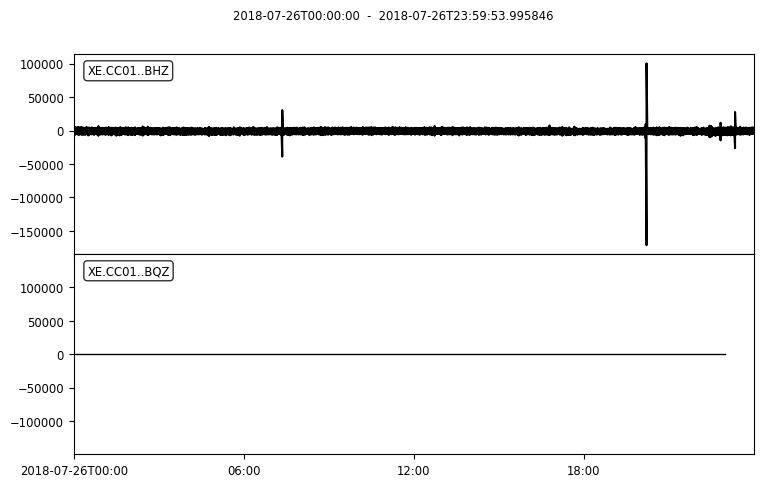

In [22]:
st.plot();

In [ ]:
class QualityMetrics:
    """
    A class for handling seismic station quality metrics from OBSIC.
    
    This class provides methods to fetch, analyze, and work with quality data
    for seismic stations, including integration with ObsPy objects.
    """
    
    def __init__(self, network_id, station_id, location_id='', channel_id='BHZ', client_name="IRIS"):
        """
        Initialize QualityMetrics object.
        
        Parameters:
        network_id (str): Network ID (e.g., 'XE')
        station_id (str): Station ID (e.g., 'CC01')
        location_id (str): Location ID (default: '')
        channel_id (str): Channel ID (e.g., 'BHZ')
        client_name (str): FDSN client name (default: "IRIS")
        """
        self.network_id = network_id
        self.station_id = station_id
        self.location_id = location_id
        self.channel_id = channel_id
        
        # Initialize FDSN client
        from obspy.clients.fdsn import Client
        self.client = Client(client_name)
        
        # Cache for quality data to avoid repeated downloads
        self._quality_data = None
        self._quality_string = None
        self._start_datetime = None
    
    def _fetch_quality_data(self):
        """
        Private method to fetch and parse quality data from OBSIC URL.
        Caches the result to avoid repeated downloads.
        """
        if self._quality_data is None:
            url = f'https://obsic-metrics.whoi.edu/static/images/quality/{self.network_id}/{self.station_id}_{self.channel_id}.txt'
            
            # Read in the data
            self._quality_data = pd.read_csv(url, delimiter=',', header=2, names=['DateTime', 'Quality'])
            
            # Concatenate the binary good/not good hourly string
            self._quality_string = ''.join(self._quality_data['Quality'].astype(str).values)
            
            # Store the start datetime for index calculations
            self._start_datetime = UTCDateTime(self._quality_data['DateTime'].iloc[0])
        
        return self._quality_data
    
    def _get_time_indices(self, starttime, endtime):
        """
        Private method to calculate start and end indices for the quality string.
        
        Parameters:
        starttime (str): Start time in ISO format
        endtime (str): End time in ISO format
        
        Returns:
        tuple: (start_index, end_index)
        """
        # Ensure quality data is loaded
        self._fetch_quality_data()
        
        start_index = int((UTCDateTime(starttime) - self._start_datetime) / 3600)
        end_index = int((UTCDateTime(endtime) - self._start_datetime) / 3600)
        
        return start_index, end_index
    
    def get_quality(self, starttime, endtime):
        """
        Get quality metrics for a given time window.
        
        Parameters:
        starttime (str): Start time in ISO format
        endtime (str): End time in ISO format
        
        Returns:
        dict: Dictionary containing percentage of good hours and quality array
        """
        # Get time indices
        start_index, end_index = self._get_time_indices(starttime, endtime)
        
        # Extract quality array for the time window
        quality_array = np.array([int(char) for char in self._quality_string[start_index:end_index+1]])
        
        # Calculate percentage of good hours
        percentage_good = quality_array.sum() / len(quality_array) * 100
        
        return {
            'percentage_good_hours': percentage_good,
            'quality_array': quality_array,
            'start_index': start_index,
            'end_index': end_index
        }
    
    def get_quality_trace(self, starttime, endtime):
        """
        Return an obspy Trace object containing quality metrics.
        
        Parameters:
        starttime (str): Start time in ISO format
        endtime (str): End time in ISO format
        
        Returns:
        obspy.Trace: Trace object containing quality metrics
        """
        from obspy import UTCDateTime, Trace
        
        # Get quality array
        quality_info = self.get_quality(starttime, endtime)
        quality_array = quality_info['quality_array']
        
        # Create trace statistics
        stats = {
            'network': self.network_id,
            'station': self.station_id,
            'location': self.location_id,
            'channel': f'{self.channel_id[0]}Q{self.channel_id[2]}',  # e.g., BHZ -> BQZ
            'npts': len(quality_array),
            'sampling_rate': 1/3600,  # 1 sample per hour
            'starttime': UTCDateTime(starttime)
        }
        
        return Trace(data=quality_array, header=stats)
    
    def get_waveforms_with_quality(self, starttime, endtime):
        """
        Get waveform data along with quality metrics.
        
        Parameters:
        starttime (str): Start time in ISO format
        endtime (str): End time in ISO format
        
        Returns:
        obspy.Stream: Stream object containing waveform data and quality trace
        """
        from obspy import UTCDateTime
        
        # Get waveform data
        stream = self.client.get_waveforms(
            self.network_id, self.station_id, self.location_id, self.channel_id,
            UTCDateTime(starttime), UTCDateTime(endtime)
        )
        
        # Add quality trace
        quality_trace = self.get_quality_trace(starttime, endtime)
        stream += quality_trace
        
        return stream
    
    def print_quality_summary(self, starttime, endtime):
        """
        Print a summary of quality metrics for the given time window.
        
        Parameters:
        starttime (str): Start time in ISO format
        endtime (str): End time in ISO format
        """
        quality_info = self.get_quality(starttime, endtime)
        percentage_good = quality_info['percentage_good_hours']
        
        print(f"Station: {self.network_id}.{self.station_id}.{self.location_id}.{self.channel_id}")
        print(f"Time window: {starttime} to {endtime}")
        print(f"Percentage good hours: {percentage_good:.1f}%")
        print(f"Quality array length: {len(quality_info['quality_array'])} hours")
    
    def __repr__(self):
        """String representation of the QualityMetrics object."""
        return f"QualityMetrics({self.network_id}.{self.station_id}.{self.location_id}.{self.channel_id})"

In [ ]:
# Example usage of the QualityMetrics class

# Create a QualityMetrics object for the same station as before
quality_analyzer = QualityMetrics(
    network_id='XE',
    station_id='CC01',
    location_id='',
    channel_id='BHZ'
)

# Use the same time window as before
starttime = '2018-07-26T00:00:00'
endtime = '2018-07-26T23:59:54'

print("=== Object-Oriented Quality Analysis ===")
print(f"Analyzer: {quality_analyzer}")
print()

# Method 1: Get quality statistics
quality_info = quality_analyzer.get_quality(starttime, endtime)
print(f"Percentage good hours: {quality_info['percentage_good_hours']:.1f}%")
print(f"Quality array shape: {quality_info['quality_array'].shape}")
print()

# Method 2: Print summary
quality_analyzer.print_quality_summary(starttime, endtime)
print()

# Method 3: Get quality trace
quality_trace = quality_analyzer.get_quality_trace(starttime, endtime)
print(f"Quality trace: {quality_trace}")
print(f"Quality trace stats: {quality_trace.stats}")
print()

# Method 4: Get waveforms with quality
stream_with_quality = quality_analyzer.get_waveforms_with_quality(starttime, endtime)
print(f"Stream with quality: {stream_with_quality}")
print("Traces in stream:")
for i, trace in enumerate(stream_with_quality):
    print(f"  {i+1}. {trace.id} - {trace.stats.npts} points")

In [ ]:
# Comparison: Old functional approach vs New OOP approach

print("=== COMPARISON: Functional vs Object-Oriented ===")
print()

# Old way (using existing functions)
print("OLD FUNCTIONAL APPROACH:")
old_result = get_quality('XE', 'CC01', '', 'BHZ', starttime, endtime)
print(f"Percentage good: {old_result['percentage_good_hours']:.1f}%")

# New way (using class)
print("\nNEW OBJECT-ORIENTED APPROACH:")
new_result = quality_analyzer.get_quality(starttime, endtime)
print(f"Percentage good: {new_result['percentage_good_hours']:.1f}%")

# Verify they give the same results
print(f"\nResults match: {np.array_equal(old_result['quality_array'], new_result['quality_array'])}")

print("\n=== ADVANTAGES OF OOP APPROACH ===")
print("✓ Data encapsulation - station info stored in object")
print("✓ Caching - quality data downloaded only once per object")  
print("✓ Reusability - same object can be used for multiple time windows")
print("✓ Extensibility - easy to add new methods")
print("✓ Clear interface - methods are well-organized and documented")
print("✓ Memory efficiency - shared data across method calls")

print("\n=== USAGE PATTERNS ===")
print("# Create once, use many times:")
print("analyzer = QualityMetrics('XE', 'CC01', '', 'BHZ')")
print("morning_quality = analyzer.get_quality('2018-07-26T06:00:00', '2018-07-26T12:00:00')")
print("evening_quality = analyzer.get_quality('2018-07-26T18:00:00', '2018-07-27T00:00:00')")
print("# Quality data is fetched only once and cached!")